<a href="https://colab.research.google.com/github/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/blob/main/6%20Data%20Cleansing%20%26%20Feature%20Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Cleansing**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install openpyxl -q
import openpyxl
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# missing data
!pip install missingno -q
import missingno as msno

# for grid
!pip install geopy -q
from geopy.distance import geodesic

#MICE
!pip install fancyimpute -q
from fancyimpute import IterativeImputer

# Pearson correletion of new features
from scipy.stats import pearsonr

# fill Host Since
from datetime import datetime, timedelta

# Set display options
%matplotlib inline
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 1000)

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.3 MB/s eta 0:00:00


In [ ]:
# apartments = pd.read_excel('https://raw.githubusercontent.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/main/apartments_4.xlsx', engine='openpyxl')

In [2]:
# import pickle

!wget https://github.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/raw/main/apartments4.pkl -q

with open('apartments4.pkl', 'rb') as f:
    apartments = pickle.load(f)

!wget https://github.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/raw/main/lat_bin.pkl -q
!wget https://github.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/raw/main/lon_bin.pkl -q

with open('lat_bin.pkl', 'rb') as f:
    lat_bin = pickle.load(f)

with open('lon_bin.pkl', 'rb') as f:
    lon_bin = pickle.load(f)


# Filling Missing Values


## Post Code

Find the nearest object with filled Post Code.
We use grid to do it quicklly

In [3]:
def fill_missing_postal_codes(apartments):

    apartments_filled = apartments.copy()
    missing_indices = apartments_filled['Postal Code'].isnull()

    for i in apartments_filled[missing_indices].index:
        lat = apartments_filled.loc[i, 'Latitude']
        lon = apartments_filled.loc[i, 'Longitude']
        lat_bin = apartments_filled.loc[i, 'Latitude_Bin']
        lon_bin = apartments_filled.loc[i, 'Longitude_Bin']

        search_radius = 1  # begin +/-1 bin
        found = False
        while not found:
            nearby_apartments = apartments_filled[
                (apartments_filled['Latitude_Bin'].between(lat_bin - search_radius, lat_bin + search_radius)) &
                (apartments_filled['Longitude_Bin'].between(lon_bin - search_radius, lon_bin + search_radius)) &
                (~apartments_filled['Postal Code'].isnull())
            ]

            if not nearby_apartments.empty:
                distances = nearby_apartments.apply(
                    lambda row: geodesic((lat, lon), (row['Latitude'], row['Longitude'])).km,
                    axis=1
                )
                nearest_index = distances.idxmin()
                apartments_filled.loc[i, 'Postal Code'] = apartments_filled.loc[nearest_index, 'Postal Code']
                found = True
            else:
                search_radius += 1

    return apartments_filled


apartments['Postal Code'] = apartments['Postal Code'].replace('nan', np.nan)
apartments = fill_missing_postal_codes(apartments)
apartments['Postal Code'].isnull().sum()

0

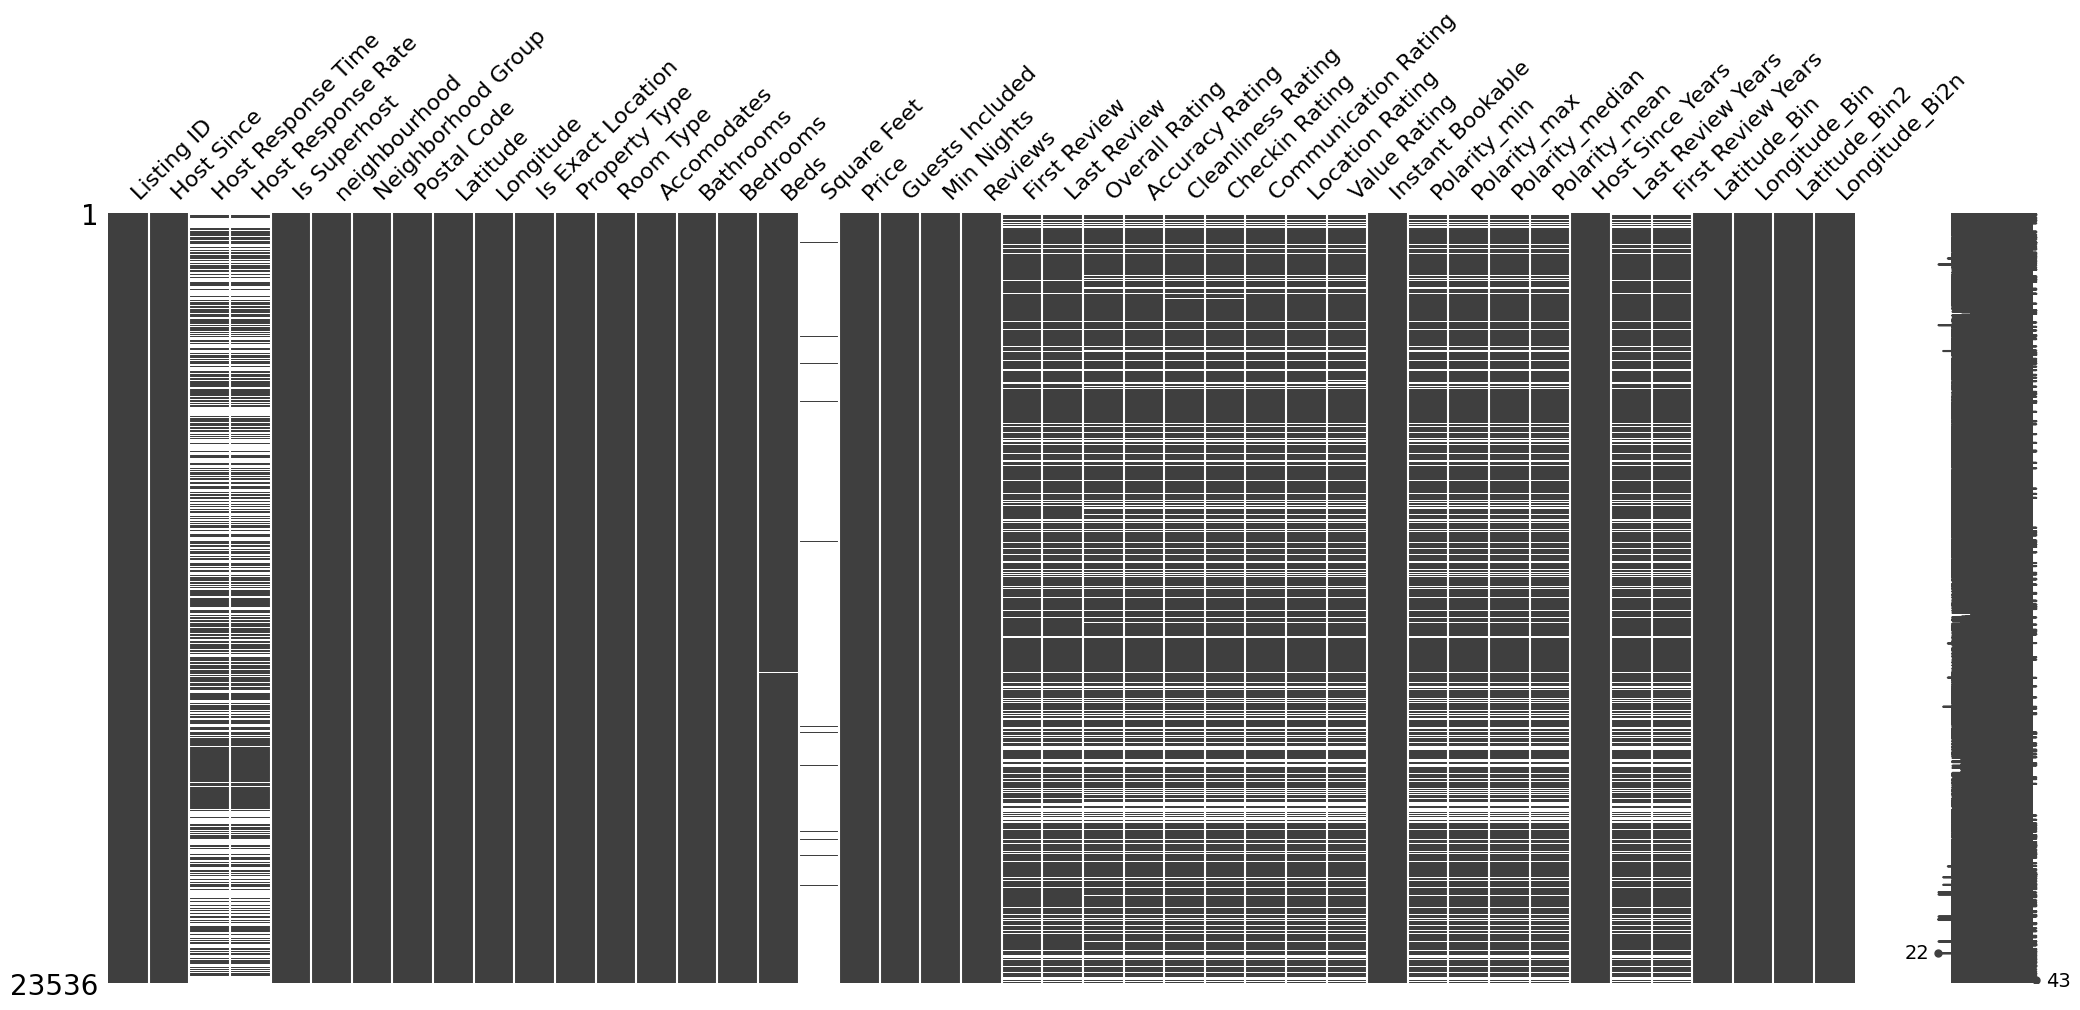

In [ ]:
msno.matrix(apartments)
plt.show()

<Axes: >

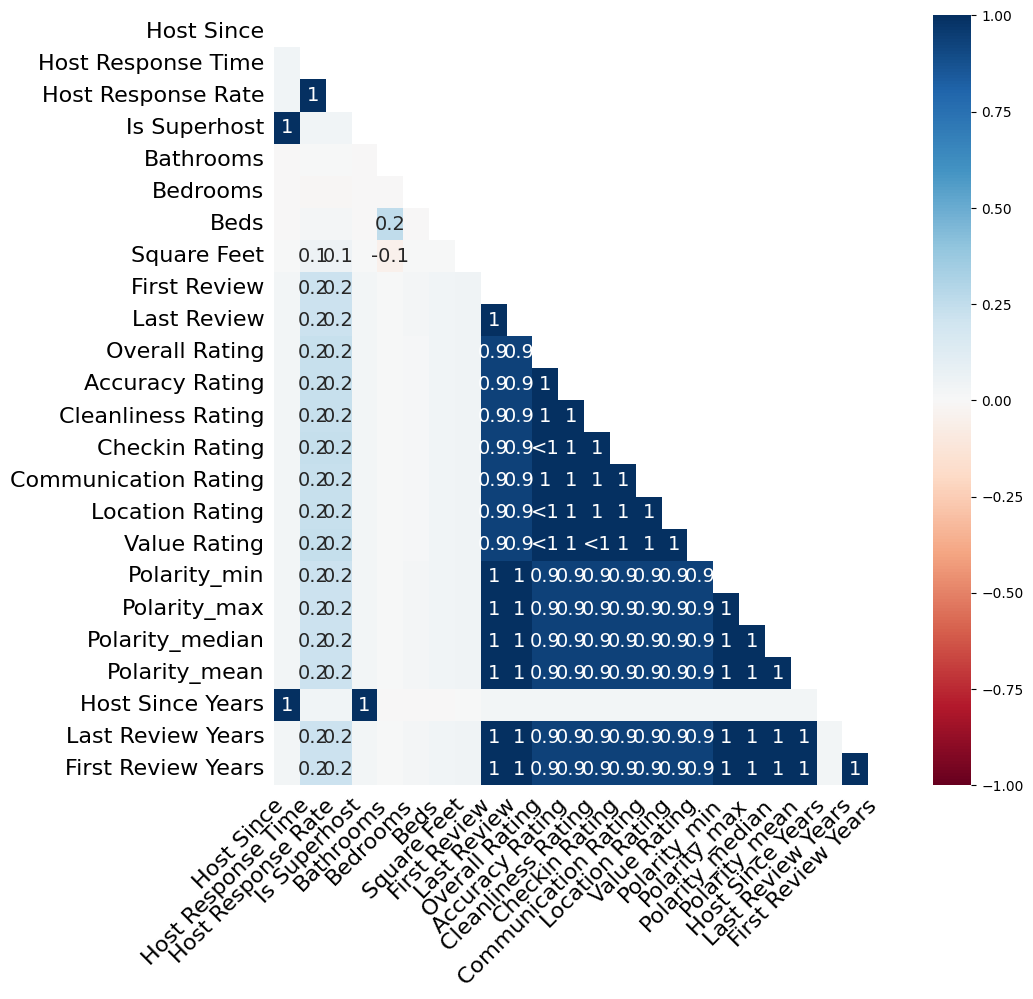

In [ ]:
msno.heatmap(apartments,figsize=(10,10))

In [ ]:
# Calculate the proportion of missing values for columns with missing data
missing_proportions = apartments.isnull().sum() / len(apartments)
print(missing_proportions[missing_proportions > 0])

Host Since              0.000892
Host Response Time      0.445700
Host Response Rate      0.445700
Is Superhost            0.000892
Bathrooms               0.001232
Bedrooms                0.000850
Beds                    0.001487
Square Feet             0.981943
First Review            0.176581
Last Review             0.176581
Overall Rating          0.196380
Accuracy Rating         0.197485
Cleanliness Rating      0.197315
Checkin Rating          0.198249
Communication Rating    0.197570
Location Rating         0.198207
Value Rating            0.198334
Polarity_min            0.176666
Polarity_max            0.176666
Polarity_median         0.176666
Polarity_mean           0.176666
Host Since Years        0.000892
Last Review Years       0.176581
First Review Years      0.176581
dtype: float64


## Filling using MICE

In [4]:
# !pip install fancyimpute -q
# from fancyimpute import IterativeImputer

apartments = apartments.reset_index(drop=True)

# Select only numeric columns for imputation
numeric_columns = apartments.select_dtypes(include=np.number).columns
apartments_numeric = apartments[numeric_columns].copy()


# Perform MICE imputation
mice_imputer = IterativeImputer()
apartments_imputed = mice_imputer.fit_transform(apartments_numeric)

# Convert the imputed array back to a DataFrame
apartments_imputed = pd.DataFrame(apartments_imputed, columns=numeric_columns)

apartments[['Bathrooms', 'Bedrooms', 'Beds']] = apartments_imputed[['Bathrooms', 'Bedrooms', 'Beds']].round(0).astype(int)
apartments['Host Since Years'] = apartments_imputed['Host Since Years']

In [ ]:
# Calculate the proportion of missing values for columns with missing data
missing_proportions = apartments.isnull().sum() / len(apartments)
print(missing_proportions[missing_proportions > 0])

Host Since              0.000892
Host Response Time      0.445700
Host Response Rate      0.445700
Is Superhost            0.000892
Square Feet             0.981943
First Review            0.176581
Last Review             0.176581
Overall Rating          0.196380
Accuracy Rating         0.197485
Cleanliness Rating      0.197315
Checkin Rating          0.198249
Communication Rating    0.197570
Location Rating         0.198207
Value Rating            0.198334
Polarity_min            0.176666
Polarity_max            0.176666
Polarity_median         0.176666
Polarity_mean           0.176666
Last Review Years       0.176581
First Review Years      0.176581
dtype: float64


In [5]:
#from datetime import datetime, timedelta

# Get today's date
today = datetime.now()

# Fill missing 'Host Since' values
for index, row in apartments.iterrows():
  if pd.isnull(row['Host Since']):
    years_as_host = row['Host Since Years']
    host_since_date = today - timedelta(days=years_as_host * 365.2425)  # Account for leap years
    apartments.loc[index, 'Host Since'] = host_since_date.strftime('%Y-%m-%d')

In [6]:
# Calculate the mode of 'Is Superhost' column
mode = apartments['Is Superhost'].mode()[0]
# Fill missing values with the mode
apartments['Is Superhost'].fillna(mode, inplace=True)

In [ ]:
# Calculate the proportion of missing values for columns with missing data
missing_proportions = apartments.isnull().sum() / len(apartments)
print(missing_proportions[missing_proportions > 0])

Host Response Time      0.445700
Host Response Rate      0.445700
Square Feet             0.981943
First Review            0.176581
Last Review             0.176581
Overall Rating          0.196380
Accuracy Rating         0.197485
Cleanliness Rating      0.197315
Checkin Rating          0.198249
Communication Rating    0.197570
Location Rating         0.198207
Value Rating            0.198334
Polarity_min            0.176666
Polarity_max            0.176666
Polarity_median         0.176666
Polarity_mean           0.176666
Last Review Years       0.176581
First Review Years      0.176581
dtype: float64


# Selecting relevant data

In [7]:
# drop noninformtive columns 0.981943 missings
apartments = apartments.drop(['Square Feet'], axis=1)

### Type of accommodation

In [8]:
# apartments = apartments[apartments['Property Type'].isin(['Apartment', 'Condominium'])]
apartments = apartments[apartments['Room Type'] != 'Shared room']
apartments.shape

(23222, 42)

### Min Nights

In [ ]:
# apartments['Min Nights']
min_nights_counts = apartments['Min Nights'].value_counts().sort_index()
min_nights_counts_cumsum = min_nights_counts.cumsum()
min_nights_counts_percentage = min_nights_counts_cumsum / min_nights_counts_cumsum.iloc[-1] * 100

result_df = pd.DataFrame({
    'Min Nights': min_nights_counts.index,
    'Count': min_nights_counts.values,
    'Cumulative Percentage': min_nights_counts_percentage.values
})
result_df

,Min Nights,Count,Cumulative Percentage
0,1,4742,22.256641
1,2,5540,48.258706
2,3,4267,68.285929
3,4,1669,76.119403
4,5,1428,82.821740
5,6,474,85.046466
6,7,874,89.148597
7,8,68,89.467756
8,9,51,89.707125
9,10,299,91.110485


In [9]:
apartments = apartments[apartments['Min Nights'] <= 14]
apartments.shape

(21620, 42)

# Outliers

### Boxplot of Outliers

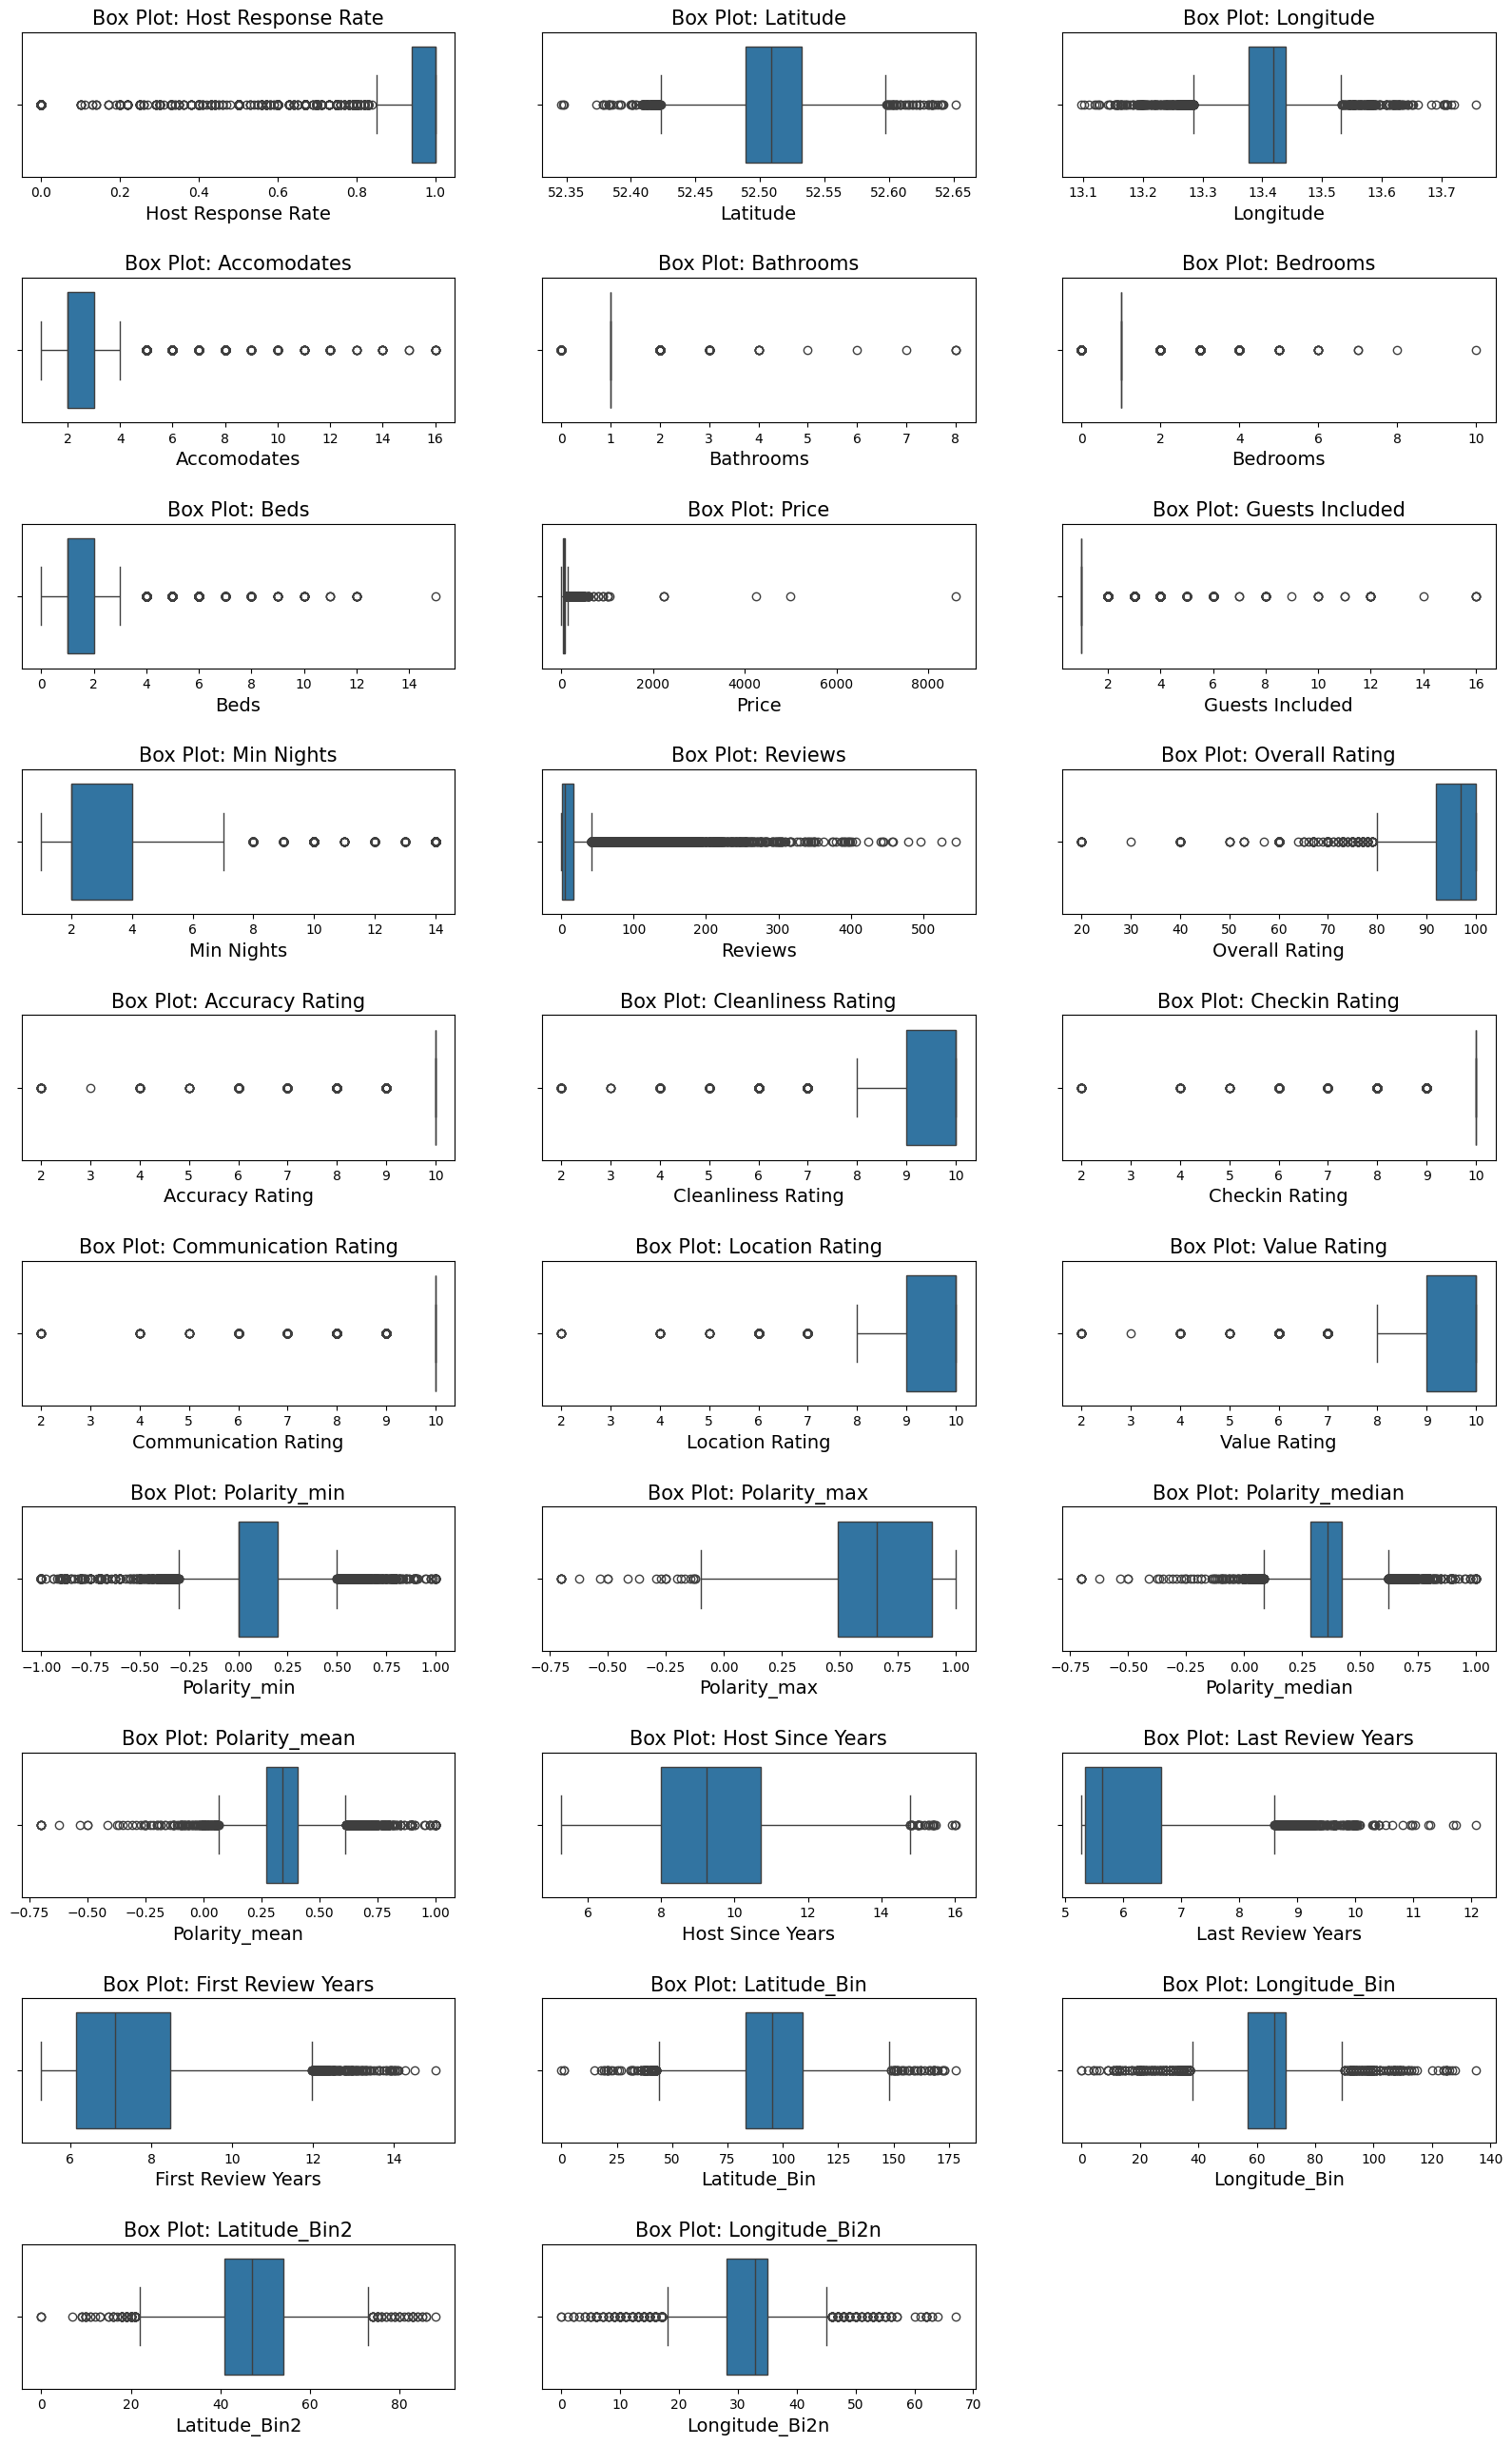

In [ ]:
numeric_cols = apartments.select_dtypes(include='number').columns

plt.figure(figsize=(20,200))

def outliers_boxplot(df):
    for i, col in enumerate(df.columns):
            ax = plt.subplot(60, 3, i+1)
            sns.boxplot(data=df, x=col, ax=ax)
            plt.subplots_adjust(hspace = 0.7)
            plt.title('Box Plot: {}'.format(col), fontsize=15)
            plt.xlabel('{}'.format(col), fontsize=14)

outliers_boxplot(apartments[numeric_cols])

### Price Outliers

Data transformation for analisis

In [ ]:
apartments['Price Log'] = np.log1p(apartments['Price'])

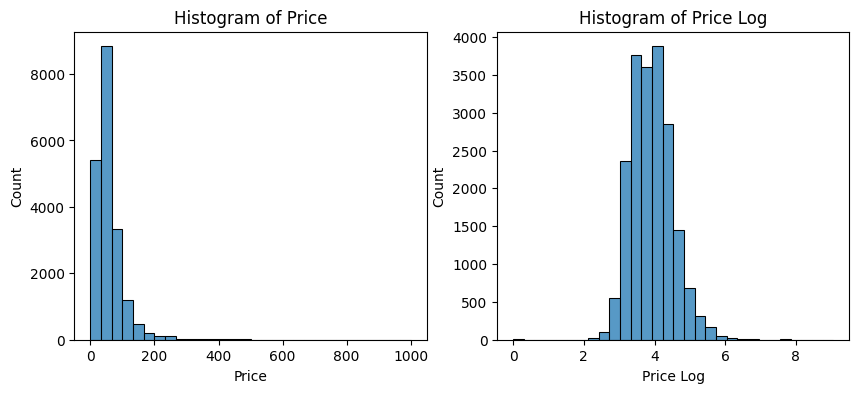

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the first and second histogram
sns.histplot(apartments[apartments['Price'] <= 1000]['Price'], bins=30, ax=axes[0])
axes[0].set_title('Histogram of Price')
sns.histplot(apartments['Price Log'], bins=30, ax=axes[1])
axes[1].set_title('Histogram of Price Log')

# plt.tight_layout()

plt.show()

In [ ]:
# Calculate mean and standard deviation of 'Price'
mean_price = apartments['Price'].mean()
std_price = apartments['Price'].std()
# Calculate +/- 3 sigma
three_sigma_lower = mean_price - 3 * std_price
three_sigma_upper = mean_price + 3 * std_price

# # Calculate 1.5 IQR
q1 = apartments['Price'].quantile(0.25)
q3 = apartments['Price'].quantile(0.75)
iqr = q3 - q1
iqr_lower = q1 - 1.5 * iqr
iqr_upper = q3 + 1.5 * iqr

print("Mean Price:", mean_price)
print("Standard Deviation Price:", std_price,'\n')
print("Сalculated boundaries based on initial data")
print("3 Sigma Lower:", three_sigma_lower)
print("3 Sigma Upper:", three_sigma_upper)
print("1.5 IQR Lower:", iqr_lower)
print("1.5 IQR Upper:", iqr_upper,'\n')


# Calculate mean and standard deviation of 'Price Log'
mean_price_log = apartments['Price Log'].mean()
std_price_log = apartments['Price Log'].std()

# Calculate +/- 3 sigma
three_sigma_lower_log = mean_price_log - 3 * std_price_log
three_sigma_upper_log = mean_price_log + 3 * std_price_log

# Calculate 1.5 IQR
q1_log = apartments['Price Log'].quantile(0.25)
q3_log = apartments['Price Log'].quantile(0.75)
iqr_log = q3_log - q1_log
iqr_lower_log = q1_log - 1.5 * iqr_log
iqr_upper_log = q3_log + 1.5 * iqr_log

# Inverse transform to get Price values
three_sigma_lower_price = np.expm1(three_sigma_lower_log)
three_sigma_upper_price = np.expm1(three_sigma_upper_log)
iqr_lower_price = np.expm1(iqr_lower_log)
iqr_upper_price = np.expm1(iqr_upper_log)

# Print results in original Price scale
print("Сalculated boundaries based on transformed data")
print("3 Sigma Lower (Price):", three_sigma_lower_price)
print("3 Sigma Upper (Price):", three_sigma_upper_price)
print("1.5 IQR Lower (Price):", iqr_lower_price)
print("1.5 IQR Upper (Price):", iqr_upper_price)


Mean Price: 60.3684926674394
Standard Deviation Price: 94.15810102262823 

Сalculated boundaries based on initial data
3 Sigma Lower: -222.1058104004453
3 Sigma Upper: 342.8427957353241
1.5 IQR Lower: -30.0
1.5 IQR Upper: 130.0 

Сalculated boundaries based on transformed data
3 Sigma Lower (Price): 7.62814984221297
3 Sigma Upper (Price): 287.2991450051594
1.5 IQR Lower (Price): 7.94368946289708
1.5 IQR Upper (Price): 245.0953065433292


In [ ]:
Q98 = apartments['Price'].quantile(0.98)
Q99 = apartments['Price'].quantile(0.99)
Q995 = apartments['Price'].quantile(0.995)

Q005 = apartments['Price'].quantile(0.005)
Q01 = apartments['Price'].quantile(0.01)
Q02 = apartments['Price'].quantile(0.02)

print("Q005", Q005)
print("Q01", Q01)
print("Q02", Q02, '\n')

print("Q98", Q98)
print("Q99", Q99)
print("Q995", Q995)

Q005 14.0
Q01 15.0
Q02 17.0 

Q98 197.15999999999985
Q99 250.0
Q995 300.0


In [10]:
apartments = apartments[(apartments['Price'] >= 14) & (apartments['Price'] <= 300)]
apartments.shape

(21334, 42)

### Outliers by apartments conditions

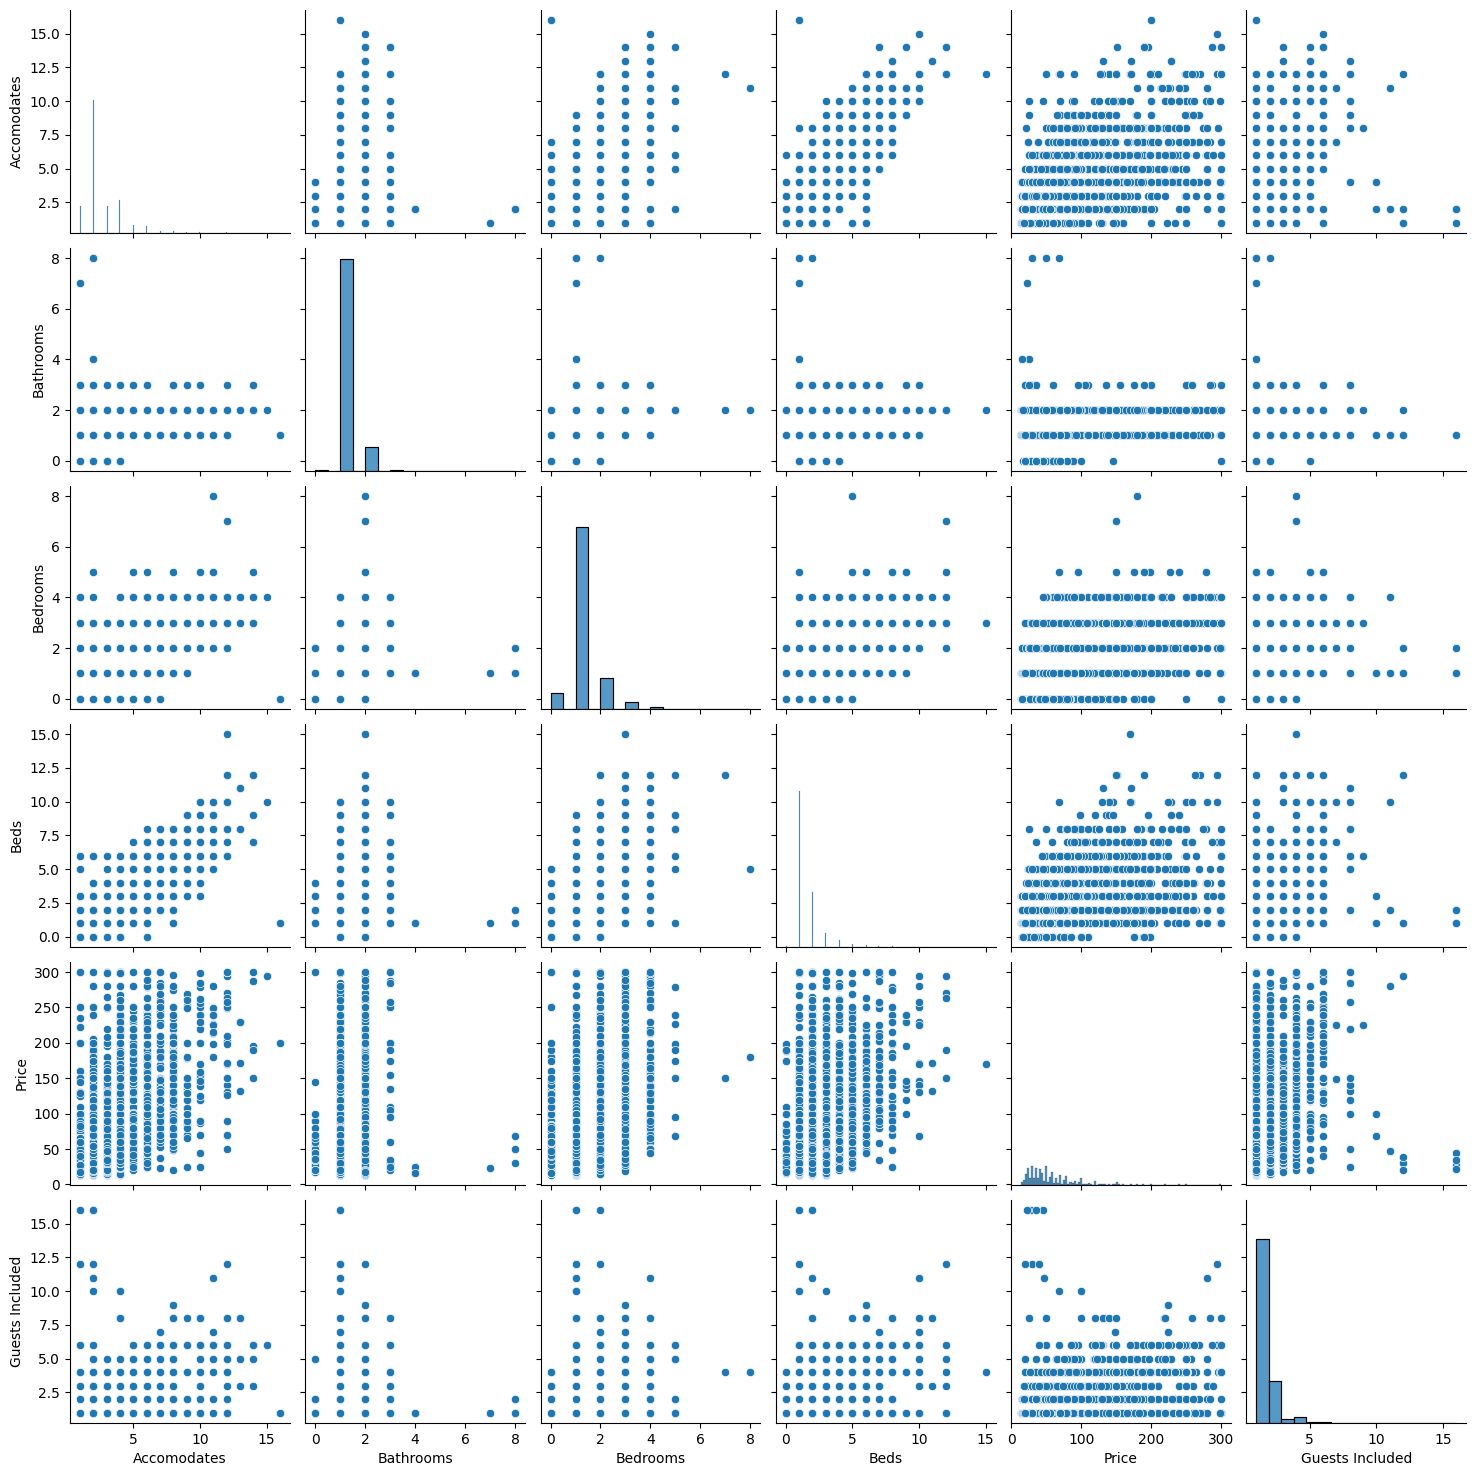

In [ ]:
columns_to_analyze = ['Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Price', 'Guests Included']

sns.pairplot(apartments[columns_to_analyze])

In [ ]:
columns_to_analyze = ['Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included']

results = []

# Пройдите по каждому столбцу и рассчитайте статистику
for col in columns_to_analyze:
    mean = apartments[col].mean()
    std = apartments[col].std()
    min_val = apartments[col].min()
    max_val = apartments[col].max()

    # Границы по 3 сигма
    three_sigma_lower = mean - 3 * std
    three_sigma_upper = mean + 3 * std

    # Границы по 1.5 IQR
    q1 = apartments[col].quantile(0.25)
    q3 = apartments[col].quantile(0.75)
    iqr = q3 - q1
    iqr_lower = q1 - 1.5 * iqr
    iqr_upper = q3 + 1.5 * iqr

    # Добавьте результаты в список
    results.append({
        'Column': col,
        'Mean': mean,
        'Std': std,
        'Min': min_val,
        'Max': max_val,
        '3 Sigma Lower': three_sigma_lower,
        '3 Sigma Upper': three_sigma_upper,
        '1.5 IQR Lower': iqr_lower,
        '1.5 IQR Upper': iqr_upper
    })

# Создайте DataFrame из списка результатов
result_df = pd.DataFrame(results)

# Выведите результаты
result_df

,Column,Mean,Std,Min,Max,3 Sigma Lower,3 Sigma Upper,1.5 IQR Lower,1.5 IQR Upper
0,Accomodates,2.599929,1.400439,1,16,-1.601387,6.801245,0.5,4.5
1,Bathrooms,1.098098,0.330190,0,8,0.107528,2.088668,1.0,1.0
2,Bedrooms,1.141934,0.598905,0,8,-0.654780,2.938649,1.0,1.0
3,Beds,1.554414,1.050274,0,15,-1.596408,4.705236,-0.5,3.5
4,Guests Included,1.323027,0.780885,1,16,-1.019628,3.665682,1.0,1.0


In [11]:
def replace_outliers_with_nan(df, boundaries):

  df_copy = df.copy()

  for column, bounds in boundaries.items():
    lower_bound, upper_bound = bounds
    df_copy[column] = np.where((df_copy[column] < lower_bound) | (df_copy[column] > upper_bound),
                               np.nan, df_copy[column])

  return df_copy

boundaries = {
    'Accomodates': (1, 7),
    'Bathrooms': (1, 2),
    'Bedrooms': (1, 4),
    'Beds': (1, 6),
    'Guests Included': (1, 6)
}

apartments = replace_outliers_with_nan(apartments, boundaries)

In [12]:
apartments = apartments.reset_index(drop=True)

# Select only numeric columns for imputation
numeric_columns = apartments.select_dtypes(include=np.number).columns
apartments_numeric = apartments[numeric_columns].copy()

# Perform MICE imputation
mice_imputer2 = IterativeImputer()
apartments_imputed = mice_imputer2.fit_transform(apartments_numeric)

# Convert the imputed array back to a DataFrame
apartments_imputed = pd.DataFrame(apartments_imputed, columns=numeric_columns)

apartments[['Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included']] = apartments_imputed[['Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included']].round(0).astype(int)


# Features engineering


In [13]:
apartments['Bin-Bin'] = apartments['Latitude_Bin'].astype(str) + '-' + apartments['Longitude_Bin'].astype(str)
apartments['Bin2-Bin2'] = apartments['Latitude_Bin2'].astype(str) + '-' + apartments['Longitude_Bi2n'].astype(str)

**logarithmic transformation.**
The linear model difficulty use features with heavy tails distribution.
Let's do a logarithmic transformation

In [14]:
# New features for analysis
apartments['Reviews Log'] = np.log1p(apartments['Reviews'])

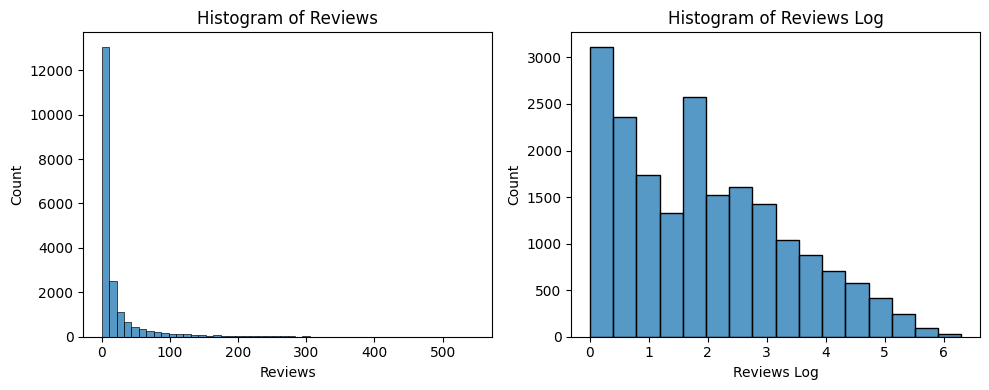

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the first and second histogram
sns.histplot(apartments['Reviews'], bins=50, ax=axes[0])
axes[0].set_title('Histogram of Reviews')
sns.histplot(apartments['Reviews Log'], bins=16, ax=axes[1])
axes[1].set_title('Histogram of Reviews Log')

plt.tight_layout()
plt.show()

**Distance from the center of the City**

In [15]:
# Calculate mean latitude and longitude
mean_latitude = apartments['Latitude'].mean()
mean_longitude = apartments['Longitude'].mean()

# Calculate distance from center for each record
apartments['Distance_from_center'] = apartments.apply(
    lambda row: geodesic(
        (row['Latitude'], row['Longitude']),
        (mean_latitude, mean_longitude)
    ).km,
    axis=1
)


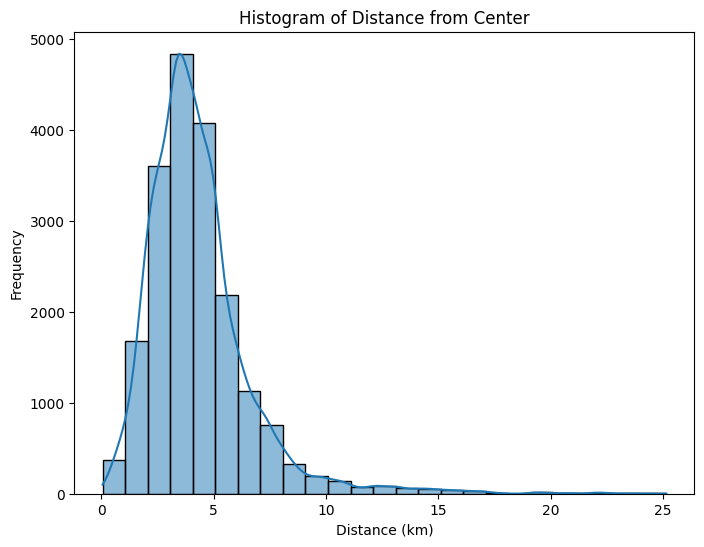

In [ ]:
# Plotting the histogram
plt.figure(figsize=(8, 6))
sns.histplot(apartments['Distance_from_center'], bins=25, kde=True)
plt.title('Histogram of Distance from Center')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
mean_dist = apartments['Distance_from_center'].mean()
std_dist = apartments['Distance_from_center'].std()
# Calculate +/- 3 sigma
dist_three_sigma_lower = mean_dist - 3 * std_dist
dist_three_sigma_upper = mean_dist + 3 * std_dist
print("Mean Distance:", mean_dist)
print("Standard Deviation Distance:", std_dist,'\n')
print("Сalculated boundaries")
print("3 Sigma Lower:", dist_three_sigma_lower)
print("3 Sigma Upper:", dist_three_sigma_upper,'\n')

Q98 = apartments['Distance_from_center'].quantile(0.98)
Q99 = apartments['Distance_from_center'].quantile(0.99)
Q995 = apartments['Distance_from_center'].quantile(0.995)

Q005 = apartments['Distance_from_center'].quantile(0.005)
Q01 = apartments['Distance_from_center'].quantile(0.01)
Q02 = apartments['Distance_from_center'].quantile(0.02)

print("Q005", Q005)
print("Q01", Q01)
print("Q02", Q02, '\n')

print("Q98", Q98)
print("Q99", Q99)
print("Q995", Q995)

Mean Distance: 4.317328434467968
Standard Deviation Distance: 2.3454123924429164 

Сalculated boundaries
3 Sigma Lower: -2.7189087428607808
3 Sigma Upper: 11.353565611796718 

Q005 0.5891890788354124
Q01 0.7632323775261073
Q02 1.0977804055901659 

Q98 11.04656262840655
Q99 13.619372433429444
Q995 15.566063486655258


In [ ]:
# from scipy.stats import pearsonr

# Calculate Pearson correlation coefficient and p-value
corr, p_value = pearsonr(apartments['Price'], apartments['Distance_from_center'])

print("Pearson correlation coefficient:", corr)
print("P-value:", p_value)


Pearson correlation coefficient: -0.11041643219712008
P-value: 2.1725082807884443e-54


In [ ]:
# apartments = apartments[apartments['Distance_from_center'] <= 17]
# apartments.shape

**make an indicator of the presence of comments and ratings**

In [16]:
apartments['Is Rating'] = apartments['Overall Rating'].notna().astype(int)

In [17]:
# if Overall Rating is NaN  - make 'Polarity_min', 'Polarity_max', 'Polarity_median', 'Polarity_mean' is NaN
apartments.loc[apartments['Overall Rating'].isna(), ['Polarity_min', 'Polarity_max', 'Polarity_median', 'Polarity_mean']] = np.nan

In [18]:
# apartments.to_excel('apartments_5.xlsx', index=False)

# import pickle

with open('apartments5.pkl', 'wb') as f:
    pickle.dump(apartments, f)
